In [1]:
#@title Installs
!pip install einops -q
!pip install torchvision -q --upgrade
!pip install transformers==4.26.1 -q
!pip install genomic-benchmarks -q
!pip install OmegaConf -q
!pip install biopython -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.26.1 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00


In [2]:
#@title Imports
# for HyenaDNA specifically
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
import pickle
import torch.optim as optim

import torch
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from typing import Optional
from functools import partial
from torch import Tensor
from torchvision.ops import StochasticDepth
from collections import namedtuple

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
# Source https://colab.research.google.com/github/zaneveld/full_spectrum_bioinformatics/blob/master/content/06_biological_sequences/reading_and_writing_fasta_files.ipynb#scrollTo=677r1vT71nCE
def parse_fasta_file(input_file):
    """Return a dict of {id:gene_seq} pairs based on the sequences in the input FASTA file
    input_file -- a file handle for an input fasta file
    """
    f = open(input_file)
    parsed_seqs = {}
    curr_seq_id = None
    curr_seq = []

    for line in f:
        line = line.strip()

        if line.startswith(">"):
            if curr_seq_id is not None:
                parsed_seqs[curr_seq_id] = ''.join(curr_seq)

            curr_seq_id = line[1:]
            curr_seq = []
            continue

        curr_seq.append(line)

    #Add the final sequence to the dict
    parsed_seqs[curr_seq_id] = ''.join(curr_seq)
    return parsed_seqs

# sbatch --output TRIAL10_avgmask_rep2Test_JingtaoHVG_filtered_seed6440.out train_model1_seed6440.sh

In [ ]:
# miRNA-target labels
miRNA_target_labels_filepath = "/content/drive/MyDrive/hsa_MTI.csv"
miRNA_target_labels_df = pd.read_csv(miRNA_target_labels_filepath)
miRNA_target_labels_df

miRTarBase ID            miRNA Species (miRNA) Target Gene  \
0         MIRT000002   hsa-miR-20a-5p    Homo sapiens       HIF1A   
1         MIRT000002   hsa-miR-20a-5p    Homo sapiens       HIF1A   
2         MIRT000002   hsa-miR-20a-5p    Homo sapiens       HIF1A   
3         MIRT000006  hsa-miR-146a-5p    Homo sapiens       CXCR4   
4         MIRT000006  hsa-miR-146a-5p    Homo sapiens       CXCR4   
...              ...              ...             ...         ...   
502647    MIRT791174      hsa-miR-943    Homo sapiens       TULP4   
502648    MIRT791175    hsa-miR-96-5p    Homo sapiens      PFKFB3   
502649    MIRT791176    hsa-miR-96-5p    Homo sapiens        RGS2   
502650    MIRT791177   hsa-miR-99a-5p    Homo sapiens       IFIT3   
502651    MIRT791178   hsa-miR-99b-5p    Homo sapiens       IFIT3   

        Target Gene (Entrez Gene ID) Species (Target Gene)  \
0                               3091          Homo sapiens   
1                               3091          Homo sapiens   
2                               3091          Homo sapiens   
3                               7852          Homo sapiens   
4                               7852          Homo sapiens   
...                              ...                   ...   
502647                         56995          Homo sapiens   
502648                          5209          Homo sapiens   
502649                          5997          Homo sapiens   
502650                          3437          Homo sapiens   
502651                          3437          Homo sapiens   

                                              Experiments  \
0       Luciferase reporter assay//Western blot//North...   
1                                               HITS-CLIP   
2        Luciferase reporter assay//qRT-PCR//Western blot   
3        qRT-PCR//Luciferase reporter assay//Western blot   
4                                              Microarray   
...                                                   ...   
502647                                          HITS-CLIP   
502648                                          HITS-CLIP   
502649                                          HITS-CLIP   
502650                                          HITS-CLIP   
502651                                          HITS-CLIP   

                 Support Type  References (PMID)  
0              Functional MTI           18632605  
1       Functional MTI (Weak)           22473208  
2              Functional MTI           23911400  
3              Functional MTI           18568019  
4       Functional MTI (Weak)           20375304  
...                       ...                ...  
502647  Functional MTI (Weak)           28735896  
502648  Functional MTI (Weak)           28735896  
502649  Functional MTI (Weak)           28735896  
502650  Functional MTI (Weak)           28735896  
502651  Functional MTI (Weak)           28735896  

[502652 rows x 9 columns]

In [ ]:
# miRNA FASTA sequences
mi_RNA_filepath = "/content/drive/MyDrive/mature.fa"
mi_RNA_dic = parse_fasta_file(mi_RNA_filepath)
print(mi_RNA_dic)

{'cel-let-7-5p MIMAT0000001 Caenorhabditis elegans let-7-5p': 'UGAGGUAGUAGGUUGUAUAGUU', 'cel-let-7-3p MIMAT0015091 Caenorhabditis elegans let-7-3p': 'CUAUGCAAUUUUCUACCUUACC', 'cel-lin-4-5p MIMAT0000002 Caenorhabditis elegans lin-4-5p': 'UCCCUGAGACCUCAAGUGUGA', 'cel-lin-4-3p MIMAT0015092 Caenorhabditis elegans lin-4-3p': 'ACACCUGGGCUCUCCGGGUACC', 'cel-miR-1-5p MIMAT0020301 Caenorhabditis elegans miR-1-5p': 'CAUACUUCCUUACAUGCCCAUA', 'cel-miR-1-3p MIMAT0000003 Caenorhabditis elegans miR-1-3p': 'UGGAAUGUAAAGAAGUAUGUA', 'cel-miR-2-5p MIMAT0020302 Caenorhabditis elegans miR-2-5p': 'CAUCAAAGCGGUGGUUGAUGUG', 'cel-miR-2-3p MIMAT0000004 Caenorhabditis elegans miR-2-3p': 'UAUCACAGCCAGCUUUGAUGUGC', 'cel-miR-34-5p MIMAT0000005 Caenorhabditis elegans miR-34-5p': 'AGGCAGUGUGGUUAGCUGGUUG', 'cel-miR-34-3p MIMAT0015093 Caenorhabditis elegans miR-34-3p': 'ACGGCUACCUUCACUGCCACCC', 'cel-miR-35-5p MIMAT0020303 Caenorhabditis elegans miR-35-5p': 'UGCUGGUUUCUUCCACAGUGGUA', 'cel-miR-35-3p MIMAT0000006 Caenorha

In [ ]:
# mRNA 3’ UTR FASTA sequences
mRNA_3_UTR_FASTA_filepath = "/content/drive/MyDrive/ensembl_biomart_human_3utr"
m_RNA_3_UTR_FASTA_dic = parse_fasta_file(mRNA_3_UTR_FASTA_filepath) # Too big to print
first_key = next(iter(m_RNA_3_UTR_FASTA_dic))

In [ ]:
def adjust_strings(input_dict, length):
    result = {}
    for key, value in input_dict.items():
        new_key = key.split('|')[2]
        if len(value) > length:
            result[new_key] = value[:length]  # Trim to first "length" characters
        else:
            result[new_key] = value.ljust(length, 'N')  # Pad with 'N' to 500 characters
    return result

# Have to change seq in class HyenaFilter and l_max
length = 500
mrna_3_UTR = adjust_strings(m_RNA_3_UTR_FASTA_dic, length)
for key, value in list(mrna_3_UTR.items())[:10]:
  print(key, len(value))
# print(mrna_3_UTR)

NDUFAF7 500
ESRRA 500
DBNDD1 500
FKBP4 500
HS3ST1 500
CFTR 500
SLC7A2 500
USP28 500
HSPB6 500
NIPAL3 500


# True Positive Pairs

In [ ]:
print(len(mi_RNA_dic))
print(len(mrna_3_UTR))
print(len(m_RNA_3_UTR_FASTA_dic))
# Create postive pairs

48885
19406
100025


In [ ]:
lol = "s"
while len(lol) < 23:
  lol += "N"
print(lol)
print(len(lol))

sNNNNNNNNNNNNNNNNNNNNNN
23


In [ ]:
# Positive MTI pairs
true_MTI_pairs = []
miRNA_set = set(miRNA_target_labels_df['miRNA'])
for miRNA_id, miRNA_seq in mi_RNA_dic.items():
  if miRNA_id[:12] in miRNA_set:
    target_gene = miRNA_target_labels_df.loc[miRNA_target_labels_df['miRNA'] == miRNA_id[:12], 'Target Gene']

    gene_set = set(target_gene)

    for gene in gene_set:
      if gene in mrna_3_UTR.keys():
        mRNA_seq = mrna_3_UTR[gene]

        if mRNA_seq[0] not in ['A', 'C', 'G', 'T', 'U']:
          continue

        while len(miRNA_seq) < 34:
          miRNA_seq += "N"

        MTI_pair = mRNA_seq + "NNNNNN" + miRNA_seq
        true_MTI_pairs.append(MTI_pair)
    # if target_gene in mrna_3_UTR.keys():
    #   mRNA_seq = mrna_3_UTR[target_gene]
    #   MTI_pair = mRNA_seq + "NNNNNN" + miRNA_seq
    #   true_MTI_pairs.append(MTI_pair)

# print(true_MTI_pairs[:3])
print(len(true_MTI_pairs))

58248


In [ ]:
print(len(true_MTI_pairs[0]))

540


In [ ]:
with open('true_MTI_pairs.pkl', 'wb') as file:
    pickle.dump(true_MTI_pairs, file)

In [ ]:
with open('true_MTI_pairs.pkl', 'rb') as file:
    true_MTI_pairs = pickle.load(file)

# Negative Pairs

In [ ]:
linker_sequence = 'NNNNNN'

# Create negative pairs

def random_pair_and_concatenate(mrna, mirna):
    # Get the list of keys and values from each dictionary
    gene = list(mrna.values())
    mirna_vals = list(mirna.values())

    result = []
    for _ in range(75000):
        # Pick a random string from the shorter dictionary when it runs out
        target = random.choice(gene)
        mi_rna = random.choice(mirna_vals)

        if target[0] not in ['A', 'C', 'G', 'T', 'U']:
          continue

        while len(mi_rna) < 34:
          mi_rna += "N"

        # Concatenate with 'NNNNNN' in between
        concatenated_string = target + linker_sequence + mi_rna

        # Store in the result dictionary with the key from the longer dictionary
        result.append(concatenated_string)

    return result


negative_MTI_pairs = random_pair_and_concatenate(mrna_3_UTR, mi_RNA_dic)
print(negative_MTI_pairs[0])


GGTGGCTGGGGAGATGTCAGGGGAAAGATAGATAGTTGTAAAAACTCTAAAGCTTTAATATATTCGGTTTGTATGTAATGGAAGCACGGGGCTAGAGTTTCCACATAGGCCCCAACATAAAGGCCTTCCCTCGCTGTTGAGGCCACCATGCCTTACTGCATCCAGCCAGGCTGCAGGGAGTGAGGCACACGGTGAACATGGCCACTGACTTTTCTGCCACTCTAACTGGACAACTGGAAGACTTGGAAAGGCCTCCACCTGTATCTACACTCTGAGGGCCCTGGACTGGGCCTGAGCTTGCCACAGAGGCTCCGTCTGACTGTGGGCTGGGAGGAGGGAGGCAGGGGAGAGCCGGTCACGGTGGCTGGTCTTTACTGCAGGGCAGCACTGTGGCCAGCTGTCTGTCTTTACACTGCATGCAGAAGTTTAAACACTGAAGTGCCGAAGTGGCCCGTGCCGCCGCACAGAGACCCCGACTTTAGTTTGGGCTGTTCCACGCTNNNNNNUUCCCUUUGUCAUCCUUUGCCUNNNNNNNNNNNN


In [ ]:
negative_MTI_pairs[2]

'AGAGGTGGGGGAGGTGACAGGGAGCTAGGCAGCCGTGCTCCCTCCAGTGCGGACTTGTCTCCCTCTGAGGGAGGCAAGAGGCTGGCGATCAGGGATCTTGTTGCATTGGGAGCAGGGGCGGCTCTCCTGGTCCCCAGGAGAGATGCTTTGAGGAGCATTCCTCTAGATTGCACAAGGGACAGTGCCTTTAACCAAGCGAGGAGTCCAAAGCTCAGGACCTGACTACCCTGAGGGCACGCTGACGCCTCTTCCCAGGGGGATGGGGAGCTTTCTGCACCCCCAGTGGCATCTCCTCATCACGTTCTGTGCCGTCCTTGGGAAAGGCCTGCATTCTGATCCTTCCAGGCCCTTCGAGCATGGAGGGGCACTGGGGAAGGTCCCCCGAGGGAGGAGCACGTTGCTGAGTAAAGAGGTGTTACTCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNUAAUGGGCUCUGCAUAGAUGGNNNNNNNNNNNNN'

In [ ]:
len(negative_MTI_pairs[2])

540

# Tokenizer, Dataset and Dataloader

Create Dataset and Dataloader

In [ ]:
# Create combined data and labels
sequences = true_MTI_pairs + negative_MTI_pairs
labels = [1] * len(true_MTI_pairs) + [0] * len(negative_MTI_pairs)

In [3]:
# Tokenizer
class SimpleRNATokenizer:
    def __init__(self):
        self.vocab = {'A': 0, 'C': 1, 'U': 2, 'G': 3, 'T': 4, 'N': 5}
        self.ids_to_tokens = {v: k for k, v in self.vocab.items()}

    def encode(self, sequence):
        if 'S' in sequence:
          print(sequence)
        # print('S' in sequence)
        return [self.vocab[char] for char in sequence]

    def decode(self, token_ids):
        return ''.join([self.ids_to_tokens[token_id] for token_id in token_ids])
tokenizer = SimpleRNATokenizer()

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

class DNADataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Tokenize the RNA sequence
        tokenized_sequence = torch.tensor(self.tokenizer.encode(self.sequences[idx]))
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return tokenized_sequence, label

In [ ]:
from sklearn.model_selection import train_test_split
import random

# Combine sequences and labels into a list of pairs
combined = list(zip(sequences, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list back into sequences and labels
sequences, labels = zip(*combined)
# Split the dataset
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

# Create training and testing datasets
train_dataset = DNADataset(train_sequences, train_labels, tokenizer)
test_dataset = DNADataset(test_sequences, test_labels, tokenizer)

# Create training and testing dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False)

# Test DataLoader
# dataset[0]

In [ ]:
len(train_dataset[0][0])

540

In [ ]:
train_dataloader

# HyenaDNA model



In [6]:
#@title Hyena layer


def fftconv(u, k, D):
    """
    We apply a convolution through the fourier domain (from the Convolution Theorem)

    """
    seqlen = u.shape[-1]
    fft_size = 2 * seqlen

    k_f = torch.fft.rfft(k, n=fft_size) / fft_size
    u_f = torch.fft.rfft(u.to(dtype=k.dtype), n=fft_size)

    if len(u.shape) > 3: k_f = k_f.unsqueeze(1)
    y = torch.fft.irfft(u_f * k_f, n=fft_size, norm='forward')[..., :seqlen]

    out = y + u * D.unsqueeze(-1)
    return out.to(dtype=u.dtype)


@torch.jit.script
def mul_sum(q, y):
    return (q * y).sum(dim=1)

class OptimModule(nn.Module):
    """ Interface for Module that allows registering buffers/parameters with configurable optimizer hyperparameters """

    def register(self, name, tensor, lr=None, wd=0.0):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {}
            if lr is not None: optim["lr"] = lr
            if wd is not None: optim["weight_decay"] = wd
            setattr(getattr(self, name), "_optim", optim)


class Sin(nn.Module):
    """The Sin activation function for the Hyena Filter function."""
    def __init__(self, dim, w=10, train_freq=True):
        super().__init__()
        self.freq = nn.Parameter(w * torch.ones(1, dim)) if train_freq else w * torch.ones(1, dim)

    def forward(self, x):
        return torch.sin(self.freq * x)


class PositionalEmbedding(OptimModule):
    def __init__(self, emb_dim: int, seq_len: int, lr_pos_emb: float=1e-5, **kwargs):
        """Complex exponential positional embeddings for Hyena filters."""
        super().__init__()

        self.seq_len = seq_len
        # The time embedding fed to the filteres is normalized so that t_f = 1
        t = torch.linspace(0, 1, self.seq_len)[None, :, None] # 1, L, 1

        if emb_dim > 1:
            bands = (emb_dim - 1) // 2
        # To compute the right embeddings we use the "proper" linspace
        t_rescaled = torch.linspace(0, seq_len - 1, seq_len)[None, :, None]
        w = 2 * math.pi * t_rescaled / seq_len # 1, L, 1

        f = torch.linspace(1e-4, bands - 1, bands)[None, None]
        z = torch.exp(-1j * f * w)
        z = torch.cat([t, z.real, z.imag], dim=-1)
        self.register("z", z, lr=lr_pos_emb)
        self.register("t", t, lr=0.0)

    def forward(self, L):
        return self.z[:, :L], self.t[:, :L]


class ExponentialModulation(OptimModule):
    """The window function applied to the output of the (MLP) filter function."""
    def __init__(
        self,
        d_model,
        fast_decay_pct=0.3,
        slow_decay_pct=1.5,
        target=1e-2,
        modulation_lr=0.0,
        modulate: bool=True,
        shift: float = 0.05,
        **kwargs
    ):
        super().__init__()
        self.modulate = modulate
        self.shift = shift
        max_decay = math.log(target) / fast_decay_pct
        min_decay = math.log(target) / slow_decay_pct
        deltas = torch.linspace(min_decay, max_decay, d_model)[None, None]
        self.register("deltas", deltas, lr=modulation_lr)

    def forward(self, t, x):
        if self.modulate:
            decay = torch.exp(-t * self.deltas.abs())
            x = x * (decay + self.shift)
        return x


class HyenaFilter(OptimModule):
    def __init__(
            self,
            d_model,
            emb_dim=3, # dim of input to MLP, augments with positional encoding
            order=16, # width of the implicit MLP
            fused_fft_conv=False,
            seq_len=5040, # CHANGE THIS
            lr=1e-3,
            lr_pos_emb=1e-5,
            dropout=0.0,
            w=1, # frequency of periodic activations
            wd=0, # weight decay of kernel parameters
            bias=True,
            num_inner_mlps=2,
            normalized=False,
            **kwargs
        ):
        """
        Implicit long filter with modulation.

        Args:
            d_model: number of channels in the input
            emb_dim: dimension of the positional encoding (`emb_dim` - 1) // 2 is the number of bands
            order: width of the FFN
            num_inner_mlps: number of inner linear layers inside filter MLP

        Note:
            filter_dropout is not implemented
        """
        super().__init__()

        self.d_model = d_model
        self.use_bias = bias
        self.fused_fft_conv = fused_fft_conv
        self.bias = nn.Parameter(torch.randn(self.d_model))
        self.dropout = nn.Dropout(dropout)

        act = Sin(dim=order, w=w)
        self.emb_dim = emb_dim
        assert emb_dim % 2 != 0 and emb_dim >= 3, "emb_dim must be odd and greater or equal to 3 (time, sine and cosine)"
        self.seq_len = seq_len

        self.pos_emb = PositionalEmbedding(emb_dim, seq_len, lr_pos_emb)

        self.implicit_filter = nn.Sequential(
            nn.Linear(emb_dim, order),
            act,
        )
        for i in range(num_inner_mlps):
            self.implicit_filter.append(nn.Linear(order, order))
            self.implicit_filter.append(act)

        self.implicit_filter.append(nn.Linear(order, d_model, bias=False))

        self.modulation = ExponentialModulation(d_model, **kwargs)

        self.normalized = normalized
        for c in self.implicit_filter.children():
            for name, v in c.state_dict().items():
                optim = {"weight_decay": wd, "lr": lr}
                setattr(getattr(c, name), "_optim", optim)

    def filter(self, L, *args, **kwargs):
        z, t = self.pos_emb(L)
        h = self.implicit_filter(z)
        h = self.modulation(t, h)
        return h

    def forward(self, x, L, k=None, bias=None, *args, **kwargs):
        if k is None: k = self.filter(L)

        # Ensure compatibility with filters that return a tuple
        k = k[0] if type(k) is tuple else k

        y = fftconv(x, k, bias)
        return y


class HyenaOperator(nn.Module):
    def __init__(
            self,
            d_model,
            l_max=10000,
            order=2,
            filter_order=64,
            dropout=0.0,
            filter_dropout=0.0,
            **filter_args,
        ):
        r"""
        Hyena operator described in the paper https://arxiv.org/pdf/2302.10866.pdf

        Args:
            d_model (int): Dimension of the input and output embeddings (width of the layer)
            l_max: (int): Maximum input sequence length. Defaults to None
            order: (int): Depth of the Hyena recurrence. Defaults to 2
            dropout: (float): Dropout probability. Defaults to 0.0
            filter_dropout: (float): Dropout probability for the filter. Defaults to 0.0
        """
        super().__init__()

        self.d_model = d_model
        self.l_max = l_max
        self.order = order
        inner_width = d_model * (order + 1)
        self.dropout = nn.Dropout(dropout)
        self.in_proj = nn.Linear(d_model, inner_width)
        self.out_proj = nn.Linear(d_model, d_model)

        self.short_filter = nn.Conv1d(
            inner_width,
            inner_width,
            3,
            padding=2,
            groups=inner_width
        )
        self.filter_fn = HyenaFilter(
            d_model * (order - 1),
            order=filter_order,
            seq_len=l_max,
            channels=1,
            dropout=filter_dropout,
            **filter_args
        )

    def forward(self, u, *args, **kwargs):
        l = u.size(-2)
        # print(l)
        l_filter = min(l, self.l_max)
        u = self.in_proj(u)
        u = rearrange(u, 'b l d -> b d l')

        uc = self.short_filter(u)[...,:l_filter]
        *x, v = uc.split(self.d_model, dim=1)

        k = self.filter_fn.filter(l_filter)[0]
        k = rearrange(k, 'l (o d) -> o d l', o=self.order - 1)
        bias = rearrange(self.filter_fn.bias, '(o d) -> o d', o=self.order - 1)

        for o, x_i in enumerate(reversed(x[1:])):
            v = self.dropout(v * x_i)
            v = self.filter_fn(v, l_filter, k=k[o], bias=bias[o])

        y = rearrange(v * x[0], 'b d l -> b l d')

        y = self.out_proj(y)
        return y


In [7]:
#@title MLP layer

"""
The MLP layer after the mixer layer (HyenaOperator).
"""

class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, activation=F.gelu,
                 return_residual=False, device=None, dtype=None):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/mlp.py
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.return_residual = return_residual
        self.fc1 = nn.Linear(in_features, hidden_features, **factory_kwargs)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features, **factory_kwargs)

    def forward(self, x):
        y = self.fc1(x)
        y = self.activation(y)
        y = self.fc2(y)
        return y if not self.return_residual else (y, x)

In [8]:
#@title Block layer (Hyena + MLP layers)

"""
A block consists of a Mixer layer (Hyena or attention), and a MLP layer.

"""

class LinearResidual(nn.Linear):
    """Wrap nn.Linear to return the residual as well. For compatibility with FusedDense.
    """

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return super().forward(input), input

class Block(nn.Module):

    def __init__(self, dim, mixer_cls=None, mlp_cls=None, norm_cls=nn.LayerNorm,
                 dropout_cls=nn.Dropout, prenorm=True, resid_dropout1=0., resid_dropout2=0.,
                 drop_path1=0., drop_path2=0.,
                 return_residual=False,
                 residual_in_fp32=False):
        """
        From https://github.com/HazyResearch/flash-attention/blob/main/flash_attn/modules/block.py
        For prenorm=True, this Block has a slightly different structure compared to a regular
        prenorm Transformer block.
        The standard block is: LN -> MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add.
        [Ref: https://arxiv.org/abs/2002.04745]
        Here we have: Dropout -> Add -> LN -> MHA -> Dropout -> Add -> LN -> MLP, returning both
        the hidden_states (output of the MLP) and the residual.
        This is for performance reasons, as we can fuse the dropout, add and LayerNorm.
        The residual needs to be provided (except for the very first block).
        For prenorm=False, this Block has the same structure as a regular postnorm Transformer
        block: MHA -> Dropout -> Add -> LN -> MLP -> Dropout -> Add -> LN.
        return_residual: whether each of the sub-layers (mixer and mlp) will return the residual.
        This is for performance reason: for post-norm architecture, returning the input allows us
        to fuse the backward of nn.Linear with the residual connection.
        """
        super().__init__()
        self.prenorm = prenorm
        self.return_residual = return_residual
        self.residual_in_fp32 = residual_in_fp32
        if self.residual_in_fp32:
            assert self.prenorm, 'residual_in_fp32 is only compatible with prenorm=True'
        if mixer_cls is None:
            mixer_cls = partial(MHA, num_heads=dim // 64)
        if mlp_cls is None:
            mlp_cls = partial(Mlp, hidden_features=4 * dim)
        self.mixer = mixer_cls()
        self.dropout1 = dropout_cls(resid_dropout1)
        self.drop_path1 = StochasticDepth(drop_path1, mode='row')
        self.norm1 = norm_cls(dim)
        self.mlp = mlp_cls(dim)
        if not isinstance(self.mlp, nn.Identity):
            self.dropout2 = dropout_cls(resid_dropout2)
            self.drop_path2 = StochasticDepth(drop_path2, mode='row')
            self.norm2 = norm_cls(dim)

    def forward(self, hidden_states, residual = None,
                mixer_subset=None, mixer_kwargs=None):
        r"""Pass the input through the encoder layer.
        Args:
            hidden_states: the sequence to the encoder layer (required).
            residual: if postnorm, residual=None, If prenorm, hidden_states = Attn/MLP(LN(residual))
            mixer_subset: for cross-attention only. If not None, will take a subset of x
                before applying the query projection. Useful for e.g., ViT where we only care
                about the CLS token in the last layer.
        """
        if self.prenorm:
            dropped = self.drop_path1(self.dropout1(hidden_states))
            residual = (dropped + residual) if residual is not None else dropped
            hidden_states = self.norm1(residual.to(dtype=self.norm1.weight.dtype))
            if self.residual_in_fp32:
                residual = residual.to(torch.float32)
            if mixer_kwargs is None:
                mixer_kwargs = {}
            if mixer_subset is not None:
                mixer_kwargs['mixer_subset'] = mixer_subset
            hidden_states = self.mixer(hidden_states, **mixer_kwargs)
            if mixer_subset is not None:
                residual = residual[:, mixer_subset]
            if not isinstance(self.mlp, nn.Identity):
                dropped = self.drop_path2(self.dropout2(hidden_states))
                residual = (dropped + residual) if residual is not None else dropped
                hidden_states = self.norm2(residual.to(dtype=self.norm2.weight.dtype))
                if self.residual_in_fp32:
                    residual = residual.to(torch.float32)

                hidden_states = self.mlp(hidden_states)
            return hidden_states, residual
        else:
            assert residual is None
            mixer_out = self.mixer(
                hidden_states, **(mixer_kwargs if mixer_kwargs is not None else {})
            )
            if self.return_residual:  # mixer out is actually a pair here
                mixer_out, hidden_states = mixer_out

            hidden_states = self.norm1((self.drop_path1(self.dropout1(mixer_out))
                                        + hidden_states).to(dtype=self.norm1.weight.dtype))

            if not isinstance(self.mlp, nn.Identity):
                mlp_out = self.mlp(hidden_states)
                if self.return_residual:  # mlp out is actually a pair here
                    mlp_out, hidden_states = mlp_out

                hidden_states = self.norm2((self.drop_path2(self.dropout2(mlp_out))
                                            + hidden_states).to(dtype=self.norm2.weight.dtype))

            return hidden_states

def create_mixer_cls(layer=None,
                     attn_layer_idx=None, attn_cfg=None, layer_idx=None,
                     device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    if attn_layer_idx is not None and layer_idx in attn_layer_idx:
        causal = True if attn_cfg is None else attn_cfg.pop('causal', True)

        mha_cls = MHA

        mixer_cls = partial(mha_cls, causal=causal, layer_idx=layer_idx,
                            **(attn_cfg if attn_cfg is not None else {}),**factory_kwargs)
    else:
        # mixer_cls = instantiate(registry.layer, layer, partial=True, layer_idx=layer_idx, **factory_kwargs)

        mixer_cls = partial(HyenaOperator, **layer)

    return mixer_cls

def create_mlp_cls(d_model, d_inner=None, device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    inner_dim = d_inner if d_inner is not None else 4 * d_model

    mlp_cls = partial(Mlp, hidden_features=inner_dim,
                          activation=partial(F.gelu, approximate='tanh'), **factory_kwargs)

    return mlp_cls


def create_block(d_model, d_inner=None,
                 layer=None, attn_layer_idx=None,
                 attn_cfg=None, layer_norm_epsilon=1e-5,
                 resid_dropout1=0.0, resid_dropout2=0.0, residual_in_fp32=False,
                 layer_idx=None,
                 device=None, dtype=None):
    factory_kwargs = {'device': device, 'dtype': dtype}
    mixer_cls = create_mixer_cls(layer=layer,
                                 attn_layer_idx=attn_layer_idx,
                                 attn_cfg=attn_cfg, layer_idx=layer_idx,
                                 **factory_kwargs)
    mlp_cls = create_mlp_cls(d_model, d_inner=d_inner,
                             **factory_kwargs)
    norm_cls = partial(nn.LayerNorm, eps=layer_norm_epsilon, **factory_kwargs)
    block = Block(d_model, mixer_cls, mlp_cls, norm_cls=norm_cls,
                  prenorm=True, resid_dropout1=resid_dropout1, resid_dropout2=resid_dropout2,residual_in_fp32=residual_in_fp32)
    block.layer_idx = layer_idx
    return block


# https://github.com/huggingface/transformers/blob/c28d04e9e252a1a099944e325685f14d242ecdcd/src/transformers/models/gpt2/modeling_gpt2.py#L454
def _init_weights(module, n_layer, initializer_range=0.02, rescale_prenorm_residual=True,
                  glu_act=False):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=initializer_range)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, std=initializer_range)

    if rescale_prenorm_residual:
        # Reinitialize selected weights subject to the OpenAI GPT-2 Paper Scheme:
        #   > A modified initialization which accounts for the accumulation on the residual path with model depth. Scale
        #   > the weights of residual layers at initialization by a factor of 1/√N where N is the # of residual layers.
        #   >   -- GPT-2 :: https://openai.com/blog/better-language-models/
        #
        # Reference (Megatron-LM): https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/model/gpt_model.py
        for name, p in module.named_parameters():
            if name in ["out_proj.weight", "fc2.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
            # If using GLU activation for now, we scale the std by 2
            elif name in ["output_linear.0.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                if not glu_act:
                    nn.init.normal_(p, mean=0.0, std=initializer_range / math.sqrt(2 * n_layer))
                else:
                    out_features = p.shape[0]
                    # Multiplying the first half of the matrix by 2 since sigmoid scales it down by 0.5
                    # on average.
                    nn.init.normal_(p[:out_features // 2], mean=0.0, std=initializer_range / math.sqrt(2 * n_layer) * 2)



In [9]:
#@title Backbone model (stack of blocks)

"""
A backbone model consists of a stack of blocks. If you use attention, then
positional embeddings are included. When using Hyena, then the pos emb
revert to doing nothing.
"""

class GPT2Embeddings(nn.Module):

    def __init__(self, embed_dim, vocab_size, max_position_embeddings, padding_idx=None,
                 word_embed_proj_dim=None, device=None, dtype=None):
        """
            If max_position_embeddings <= 0, there's no position embeddings
            If word_embe_proj_dim is not None (e.g., OPT-350m), we embed to that dimension
                the project up to embed_dim
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if word_embed_proj_dim is None:
            self.word_embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx,
                                                **factory_kwargs)
            self.project_in = None
        else:
            self.word_embeddings = nn.Embedding(vocab_size, word_embed_proj_dim,
                                                padding_idx=padding_idx, **factory_kwargs)
            self.project_in = nn.Linear(word_embed_proj_dim, embed_dim, bias=False,
                                        **factory_kwargs)
        self.max_position_embeddings = max_position_embeddings
        if self.max_position_embeddings > 0:
            self.position_embeddings = nn.Embedding(max_position_embeddings, embed_dim,
                                                    **factory_kwargs)

    def forward(self, input_ids, position_ids=None):
        """
            input_ids: (batch, seqlen)
            position_ids: (batch, seqlen)
        """
        batch_size, seqlen = input_ids.shape
        embeddings = self.word_embeddings(input_ids)
        if self.project_in is not None:
            embeddings = self.project_in(embeddings)
        if self.max_position_embeddings > 0:
            if position_ids is None:
                position_ids = torch.arange(seqlen, dtype=torch.long, device=input_ids.device)
            position_embeddings = self.position_embeddings(position_ids)
            embeddings = embeddings + position_embeddings
        return embeddings

class LMBackbone(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 process_group=None, layer=None,
                 attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.process_group = process_group
        self.residual_in_fp32 = residual_in_fp32
        # note max_position_embeddings is 0 for Hyena, and therefore isn't used
        self.embeddings = GPT2Embeddings(d_model, vocab_size, max_position_embeddings,
                                             **factory_kwargs)

        self.layers = nn.ModuleList([create_block(
            d_model, d_inner=d_inner,
            layer=layer, attn_layer_idx=attn_layer_idx,
            attn_cfg=attn_cfg, layer_norm_epsilon=layer_norm_epsilon,
            resid_dropout1=embed_dropout if i == 0 else resid_dropout,
            resid_dropout2=resid_dropout, residual_in_fp32=residual_in_fp32,layer_idx=i,
            **factory_kwargs,
        ) for i in range(n_layer)])

        self.drop_f = nn.Dropout(resid_dropout)
        self.ln_f = nn.LayerNorm(d_model, eps=layer_norm_epsilon, **factory_kwargs)

        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

    def forward(self, input_ids, position_ids=None):
        hidden_states = self.embeddings(input_ids, position_ids=position_ids,)
        residual = None

        for layer in self.layers:
            hidden_states, residual = layer(hidden_states, residual)

        dropped = self.drop_f(hidden_states)
        residual = (dropped + residual) if residual is not None else dropped
        hidden_states = self.ln_f(residual.to(dtype=self.ln_f.weight.dtype))

        return hidden_states

In [10]:
#@title Decoder head layer

"""
A simple decoder head (using MLP) to predict a sequence level classification.
You have the option to average across all the tokens in a sequence or using the
"last" token to classify.  At least, those 2 worked best for us, but we provide
other "modes" as well.

We only need this for classification.  Otherwise we'll use the hidden
states of the backbone as embeddings.

"""


class SequenceDecoder(nn.Module):
    def __init__(
        self, d_model, d_output=None, l_output=None, use_lengths=False, mode="last"
    ):
        super().__init__()

        self.output_transform = nn.Identity() if d_output is None else nn.Linear(d_model, d_output)

        if l_output is None:
            self.l_output = None
            self.squeeze = False
        elif l_output == 0:
            # Equivalent to getting an output of length 1 and then squeezing
            self.l_output = 1
            self.squeeze = True
        else:
            assert l_output > 0
            self.l_output = l_output
            self.squeeze = False

        self.use_lengths = use_lengths
        self.mode = mode

        if mode == 'ragged':
            assert not use_lengths

    def forward(self, x, state=None, lengths=None, l_output=None):
        """
        x: (n_batch, l_seq, d_model)
        Returns: (n_batch, l_output, d_output)
        """

        if self.l_output is None:
            if l_output is not None:
                assert isinstance(l_output, int)  # Override by pass in
            else:
                # Grab entire output
                l_output = x.size(-2)
            squeeze = False
        else:
            l_output = self.l_output
            squeeze = self.squeeze

        if self.mode == "last":
            restrict = lambda x: x[..., -l_output:, :]
        elif self.mode == "first":
            restrict = lambda x: x[..., :l_output, :]
        elif self.mode == "pool":
            restrict = lambda x: (
                torch.cumsum(x, dim=-2)
                / torch.arange(
                    1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                ).unsqueeze(-1)
            )[..., -l_output:, :]

            def restrict(x):
                L = x.size(-2)
                s = x.sum(dim=-2, keepdim=True)
                if l_output > 1:
                    c = torch.cumsum(x[..., -(l_output - 1) :, :].flip(-2), dim=-2)
                    c = F.pad(c, (0, 0, 1, 0))
                    s = s - c  # (B, l_output, D)
                    s = s.flip(-2)
                denom = torch.arange(
                    L - l_output + 1, L + 1, dtype=x.dtype, device=x.device
                )
                s = s / denom
                return s

        elif self.mode == "sum":
            restrict = lambda x: torch.cumsum(x, dim=-2)[..., -l_output:, :]
            # TODO use same restrict function as pool case
        elif self.mode == 'ragged':
            assert lengths is not None, "lengths must be provided for ragged mode"
            # remove any additional padding (beyond max length of any sequence in the batch)
            restrict = lambda x: x[..., : max(lengths), :]
        else:
            raise NotImplementedError(
                "Mode must be ['last' | 'first' | 'pool' | 'sum']"
            )

        # Restrict to actual length of sequence
        if self.use_lengths:
            assert lengths is not None
            x = torch.stack(
                [
                    restrict(out[..., :length, :])
                    for out, length in zip(torch.unbind(x, dim=0), lengths)
                ],
                dim=0,
            )
        else:
            x = restrict(x)

        if squeeze:
            assert x.size(-2) == 1
            x = x.squeeze(-2)

        x = self.output_transform(x)

        return x

    def step(self, x, state=None):
        # Ignore all length logic
        return self.output_transform(x)

In [11]:
#@title Model (backbone + head)

"""
Putting it all together, the model consists of a backbone model
and a decoder head (you can turn off head for embeddings only too).

Here we use a simple head to do multi-classification, but
can also swap the head to do next token prediction too.  We defer to the main
HyenaDNA for that code, since pretraining with next token prediction isn't quite
feasible on colab.

"""

class HyenaDNAModel(nn.Module):

    def __init__(self, d_model: int, n_layer: int, d_inner: int, vocab_size: int,
                 layer=None, attn_layer_idx=None, attn_cfg=None, max_position_embeddings=0,
                 resid_dropout: float = 0.0, embed_dropout: float = 0.1,
                 layer_norm_epsilon: float = 1e-5, initializer_cfg=None,residual_in_fp32=False,
                 pad_vocab_size_multiple: int = 1, use_head=True, n_classes: int = 2,
                 device=None, dtype=None, **kwargs) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if vocab_size % pad_vocab_size_multiple != 0:
            vocab_size += pad_vocab_size_multiple - (vocab_size % pad_vocab_size_multiple)

        self.use_head = use_head

        # check if layer (config) has d_model (HF code differs from main Safari code)
        if 'd_model' not in layer:
            layer['d_model'] = d_model

        self.backbone = LMBackbone(
            d_model=d_model, n_layer=n_layer, d_inner=d_inner, vocab_size=vocab_size,
            layer=layer, attn_layer_idx=attn_layer_idx, attn_cfg=attn_cfg,
            max_position_embeddings=max_position_embeddings,
            resid_dropout=resid_dropout, embed_dropout=embed_dropout,
            layer_norm_epsilon=layer_norm_epsilon,
            initializer_cfg=initializer_cfg, residual_in_fp32=residual_in_fp32,
            **factory_kwargs, **kwargs
        )

        # we only need a head if doing classification, otherwise we'll use the
        # hidden states as embeddings
        if self.use_head:
            self.head = SequenceDecoder(d_model=d_model, d_output=n_classes, l_output=0, mode='pool')

        # Initialize weights and apply final processing
        self.apply(partial(_init_weights, n_layer=n_layer,
                           **(initializer_cfg if initializer_cfg is not None else {})))

        # if self.use_head:
        #     self.tie_weights()

    # def tie_weights(self):
    #     self.head.weight = self.backbone.embeddings.word_embeddings.weight

    def forward(self, input_ids, position_ids=None, state=None): # state for the repo interface
        hidden_states = self.backbone(input_ids, position_ids=position_ids)

        if self.use_head:
            return self.head(hidden_states)
        else:
            return hidden_states

# Fine tuning and Evaluation



Call `run_train` function twice once for fine-tuning on pre-trained hyenadna-tiny-1k-seqlen model and once for training from scratch on the same model. Your function should return both the fine-tuned or trained model and the test accraucies for the subsequent analyses.

In [ ]:
#@title Huggingface Pretrained Wrapper
# for Huggingface integration, we use a wrapper class around the model
# to load weights
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig
import re

def inject_substring(orig_str):
    """Hack to handle matching keys between models trained with and without
    gradient checkpointing."""

    # modify for mixer keys
    pattern = r"\.mixer"
    injection = ".mixer.layer"

    modified_string = re.sub(pattern, injection, orig_str)

    # modify for mlp keys
    pattern = r"\.mlp"
    injection = ".mlp.layer"

    modified_string = re.sub(pattern, injection, modified_string)

    return modified_string

def load_weights(scratch_dict, pretrained_dict, checkpointing=False):
    """Loads pretrained (backbone only) weights into the scratch state dict.

    scratch_dict: dict, a state dict from a newly initialized HyenaDNA model
    pretrained_dict: dict, a state dict from the pretrained ckpt
    checkpointing: bool, whether the gradient checkpoint flag was used in the
    pretrained model ckpt. This slightly changes state dict keys, so we patch
    that if used.

    return:
    dict, a state dict with the pretrained weights loaded (head is scratch)

    # loop thru state dict of scratch
    # find the corresponding weights in the loaded model, and set it

    """

    # need to do some state dict "surgery"
    for key, value in scratch_dict.items():
        if 'backbone' in key:
            # the state dicts differ by one prefix, '.model', so we add that
            key_loaded = 'model.' + key
            # breakpoint()
            # need to add an extra ".layer" in key
            if checkpointing:
                key_loaded = inject_substring(key_loaded)
            try:
                scratch_dict[key] = pretrained_dict[key_loaded]
            except:
                raise Exception('key mismatch in the state dicts!')

    # scratch_dict has been updated
    return scratch_dict

class HyenaDNAPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """
    base_model_prefix = "hyenadna"

    def __init__(self, config):
        pass

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs)

    # A3 task 1: TO BE MODIFIED
    @classmethod
    def from_pretrained(cls,
                        path,
                        model_name,
                        download=False,
                        config=None,
                        device='cpu',
                        use_head=False,
                        n_classes=2,
                        from_scratch=False
                      ):
        # first check if it is a local path
        pretrained_model_name_or_path = os.path.join(path, model_name)
        if os.path.isdir(pretrained_model_name_or_path) and download == False:
            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))
        else:
            hf_url = f'https://huggingface.co/LongSafari/{model_name}'

            subprocess.run(f'rm -rf {pretrained_model_name_or_path}', shell=True)
            command = f'mkdir -p {path} && cd {path} && git lfs install && git clone {hf_url}'
            subprocess.run(command, shell=True)

            if config is None:
                config = json.load(open(os.path.join(pretrained_model_name_or_path, 'config.json')))

        scratch_model = HyenaDNAModel(**config, use_head=use_head, n_classes=n_classes)  # the new model format

        if not from_scratch:
          loaded_ckpt = torch.load(
              os.path.join(pretrained_model_name_or_path, 'weights.ckpt'),
              map_location=torch.device(device)
          )

          # need to load weights slightly different if using gradient checkpointing
          if config.get("checkpoint_mixer", False):
              checkpointing = config["checkpoint_mixer"] == True or config["checkpoint_mixer"] == True
          else:
              checkpointing = False

          # grab state dict from both and load weights
          state_dict = load_weights(scratch_model.state_dict(), loaded_ckpt['state_dict'], checkpointing=checkpointing)

          # scratch model has now been updated
          scratch_model.load_state_dict(state_dict)
          print("Loaded pretrained weights ok!")

        else:
          print("Training from scratch!")
        return scratch_model


In [ ]:

"""
We provide simple training code for the GenomicBenchmark datasets.
"""
def train(model, device, train_loader, optimizer, epoch, loss_fn, log_interval=10):
    """Training loop."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target.squeeze().type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# A3 task 2: TO BE MODIFIED
def test(model, device, test_loader, loss_fn):
    """Test loop."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target.squeeze().type(torch.LongTensor).to(device)).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy


In [ ]:
import json
import os
import subprocess
import transformers
from transformers import PreTrainedModel, AutoModelForCausalLM, PretrainedConfig

# A3 task 3: TO BE MODIFIED
def run_train(from_scratch=False,length=length):

    '''
    Main entry point for training.  Select the dataset name and metadata, as
    well as model and training args, and you're off to the genomic races!

    ### GenomicBenchmarks Metadata
    # there are 8 datasets in this suite, choose 1 at a time, with their corresponding settings
    # name                                num_seqs        num_classes     median len    std
    # dummy_mouse_enhancers_ensembl       1210            2               2381          984.4
    # demo_coding_vs_intergenomic_seqs    100_000         2               200           0
    # demo_human_or_worm                  100_000         2               200           0
    # human_enhancers_cohn                27791           2               500           0
    # human_enhancers_ensembl             154842          2               269           122.6
    # human_ensembl_regulatory            289061          3               401           184.3
    # human_nontata_promoters             36131           2               251           0
    # human_ocr_ensembl                   174756          2               315           108.1

    '''
    # experiment settings:
    num_epochs = 30  # ~100 seems fine
    max_length = length  # max len of sequence of dataset (of what you want)
    use_padding = True
    dataset_name = 'dummy_mouse_enhancers_ensembl' # 'dummy_mouse_enhancers_ensembl' 'human_enhancers_cohn'
    batch_size = 256
    learning_rate = 6e-4  # good default for Hyena
    rc_aug = True  # reverse complement augmentation
    add_eos = False  # add end of sentence token
    weight_decay = 0.1

    # for fine-tuning, only the 'tiny' model can fit on colab
    # pretrained_model_name = 'hyenadna-tiny-1k-seqlen'  # use None if training from scratch
    pretrained_model_name = 'hyenadna-tiny-16k-seqlen-d128'

    # we need these for the decoder head, if using
    use_head = True
    n_classes = 2

    # you can override with your own backbone config here if you want,
    # otherwise we'll load the HF one by default
    backbone_cfg = None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # instantiate the model (pretrained here)
    if pretrained_model_name in ['hyenadna-tiny-1k-seqlen', 'hyenadna-tiny-16k-seqlen-d128']:
        # use the pretrained Huggingface wrapper instead
        model = HyenaDNAPreTrainedModel.from_pretrained(
            './checkpoints',
            pretrained_model_name,
            download=True,
            config=backbone_cfg,
            device=device,
            use_head=use_head,
            n_classes=n_classes,
            from_scratch=from_scratch
        )

    # create tokenizer
    # tokenizer = CharacterTokenizer(
    #     characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters, N is uncertain
    #     model_max_length=max_length + 2,  # to account for special tokens, like EOS
    #     add_special_tokens=False,  # we handle special tokens elsewhere
    #     padding_side='left', # since HyenaDNA is causal, we pad on the left
    # )


    # loss function
    loss_fn = nn.CrossEntropyLoss()

    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)

    test_acc_list = []
    for epoch in range(num_epochs):
        train(model, device, train_dataloader, optimizer, epoch, loss_fn)
        test_accuracy = test(model, device, test_dataloader, loss_fn)
        optimizer.step()
        test_acc_list.append(test_accuracy)

    return model, test_acc_list

In [ ]:
# launch it!
finetuned, test_acc_list_ft = run_train()  # fine-tune pre-trained model

loading datafiles and hyenamodel

In [ ]:
def save_objects(objects, filename):
    with open(filename, 'wb') as file:
        pickle.dump(objects, file)


In [ ]:
objects_to_save = {
    'train_dataloader'+str(length): train_dataloader,
    'test_dataloader'+str(length): test_dataloader,
    'finetuned'+str(length): finetuned,
    'test_acc_list_ft'+str(length): test_acc_list_ft
}

save_objects(objects_to_save, 'hyenadna_data'+str(length)+'.pkl')

In [ ]:
def load_objects(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
loaded_objects = load_objects('hyenadna_data'+str(length)+'.pkl')

train_dataloader = loaded_objects['train_dataloader'+str(length)]
test_dataloader = loaded_objects['test_dataloader'+str(length)]
fine_tuned_model = loaded_objects['finetuned'+str(length)]
test_accuracies = loaded_objects['test_acc_list_ft'+str(length)]

UnpicklingError: pickle data was truncated

In [ ]:
with open('/content/hyenadna_data.pkl', 'rb') as f:
    loaded_objects = pickle.load(f)
    # glove_words =  set(model.keys())

In [ ]:
# train_dataloader = loaded_objects['train_dataloader'+str(length)]
# test_dataloader = loaded_objects['test_dataloader'+str(length)]
# fine_tuned_model = loaded_objects['finetuned'+str(length)]
# test_accuracies = loaded_objects['test_acc_list_ft'+str(length)]
train_dataloader = loaded_objects['train_dataloader']
test_dataloader = loaded_objects['test_dataloader']
fine_tuned_model = loaded_objects['finetuned']
test_accuracies = loaded_objects['test_acc_list_ft']

In [ ]:
with open('/content/hyenadna_data.pkl', 'rb') as f:
    loaded_objects_500 = pickle.load(f)
    # glove_words =  set(model.keys())

In [ ]:
train_dataloader_500 = loaded_objects_500['train_dataloader']
test_dataloader_500 = loaded_objects_500['test_dataloader']
fine_tuned_model_500 = loaded_objects_500['finetuned']
test_accuracies_500 = loaded_objects_500['test_acc_list_ft']

Don't run this

In [12]:
import pickle
def load_objects(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

loaded_objects = load_objects('hyenadna_data.pkl')

train_dataloader = loaded_objects['train_dataloader']
test_dataloader = loaded_objects['test_dataloader']
fine_tuned_model = loaded_objects['finetuned']
test_accuracies = loaded_objects['test_acc_list_ft']

# AUROC curve for HyenaDNA

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fine_tuned_model.to(device) # Make sure the model is on the correct device
model.eval()

# Get labels and predictions
# Get predictions for the test data
y_pred_probs = []
y_true = []  # Initialize a list to store true labels

with torch.no_grad():  # Disable gradient calculations
    for data, target in test_dataloader:
        # data should be LongTensor for embedding layer
        data, target = data.to(device).long(), target.to(device).float()
        outputs = model(data).squeeze()  # Get predicted probabilities
        y_pred_probs.extend(outputs.cpu().numpy())  # Move to CPU and save predictions
        y_true.extend(target.cpu().numpy())  # Move to CPU and save true labels

y_pred_probs = np.array(y_pred_probs) # convert to numpy array
y_true = np.array(y_true) # convert to numpy array

In [ ]:
print(y_pred_probs)

[[ 2.9639084 -2.963917 ]
 [ 3.4423048 -3.442318 ]
 [ 2.8875277 -2.8875456]
 ...
 [-0.5233475  0.5233474]
 [-1.1128724  1.1128782]
 [ 2.7317288 -2.7317472]]


In [ ]:
print(y_true)

NameError: name 'length' is not defined

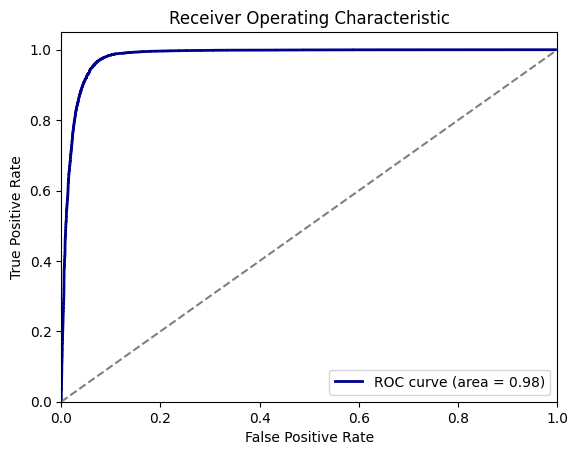

In [18]:
# Calculate ROC curve
# Assuming the positive class is represented by index 1 in the output probabilities
# Apply sigmoid activation if necessary
y_pred_probs_positive = torch.sigmoid(torch.tensor(y_pred_probs[:, 1])).numpy()

fpr, tpr, _ = roc_curve(y_true, y_pred_probs_positive) # Use probabilities for the positive class

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve_'+str(length)+'.png')
plt.show()

# Base CNN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the CNN model
class BinaryClassificationCNN(nn.Module):
    def __init__(self):
        super(BinaryClassificationCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 540, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for 1D convolution
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelcnn = BinaryClassificationCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(modelcnn.parameters(), lr=0.001)

def train_model(model, train_dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_dataloader:
            data, target = data.to(device).float(), target.to(device).float()  # Convert input data and targets to float
            optimizer.zero_grad()
            outputs = model(data)
            outputs = outputs.squeeze()  # Remove extra dimension
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}")




# Train the model
train_model(modelcnn, train_dataloader, criterion, optimizer, epochs=10)


Epoch 1/10, Loss: 0.5377
Epoch 2/10, Loss: 0.3886
Epoch 3/10, Loss: 0.3211
Epoch 4/10, Loss: 0.2770
Epoch 5/10, Loss: 0.2424
Epoch 6/10, Loss: 0.2121
Epoch 7/10, Loss: 0.1834
Epoch 8/10, Loss: 0.1621
Epoch 9/10, Loss: 0.1418
Epoch 10/10, Loss: 0.1271


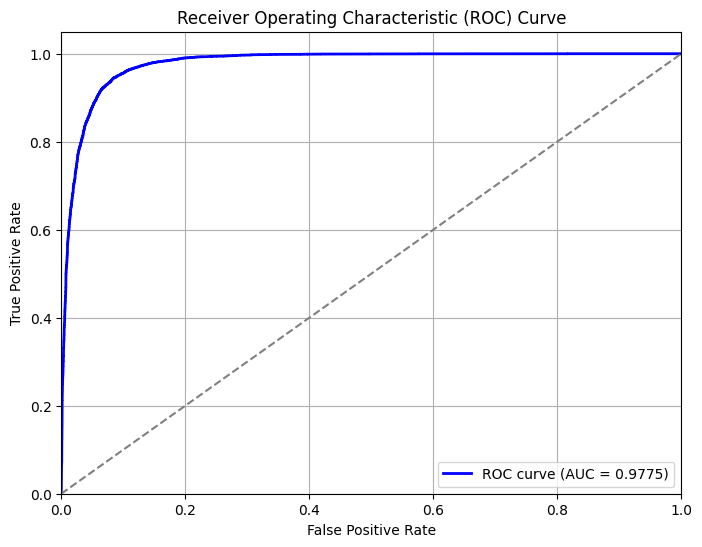

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Evaluation function to collect true labels, predicted probabilities, and test accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_targets = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculations
        for data, target in dataloader:
            data, target = data.to(device).float(), target.to(device).float()
            outputs = model(data).squeeze()  # Get predicted probabilities
            all_probs.extend(outputs.cpu().numpy())  # Move to CPU and save predictions
            all_targets.extend(target.cpu().numpy())  # Move to CPU and save true labels

    # Compute test accuracy
    predicted_classes = (np.array(all_probs) > 0.5).astype(int)  # Binarize predictions
    test_accuracy = accuracy_score(all_targets, predicted_classes)

    return all_targets, all_probs, test_accuracy


# Plot ROC curve
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


# Evaluate the model and plot the ROC curve
true_labels, predicted_probs, test_acc_cnn = evaluate_model(modelcnn, test_dataloader)
plot_roc_curve(true_labels, predicted_probs)


# Plotting both curves in the same plot

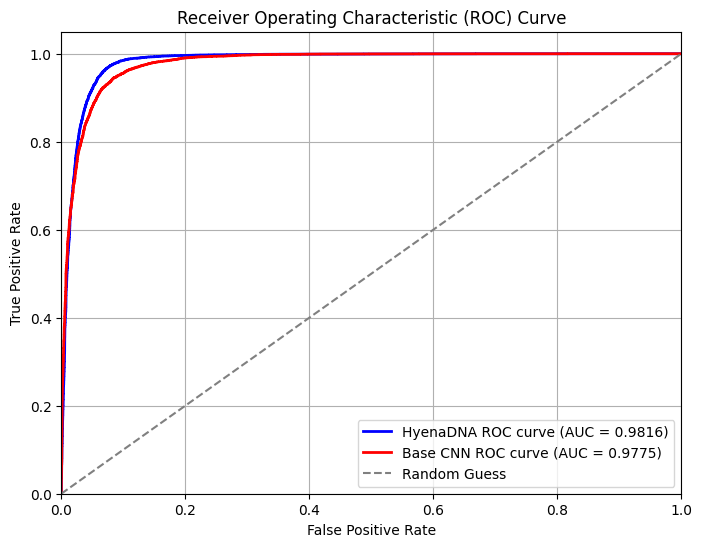

In [19]:
# Plot both ROC curves
def plot_roc_curves(true_labels1, predicted_probs1, true_labels2, predicted_probs2):
    # Calculate ROC curve and AUC for the first model
    fpr1, tpr1, _ = roc_curve(true_labels1, predicted_probs1)
    auc1 = auc(fpr1, tpr1)

    # Calculate ROC curve and AUC for the second model
    fpr2, tpr2, _ = roc_curve(true_labels2, predicted_probs2)
    auc2 = auc(fpr2, tpr2)

    # Plot both ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'HyenaDNA ROC curve (AUC = {auc1:.4f})')
    plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Base CNN ROC curve (AUC = {auc2:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_curves(y_true, y_pred_probs_positive, true_labels, predicted_probs)

# Test Accuracies

For Hyenadna model

In [13]:
best_test_accuracy_hyendna = max(test_accuracies)
best_test_accuracy_hyendna

95.43347639484979

For CNN model

In [16]:
test_acc_cnn

0.9286266094420601